### 0. Imports

In [1]:
import pandas as pd
from datetime import datetime

from statistics import mean

import sktime
from sktime.utils.plotting import plot_series

### 1. Load Data

In [2]:
pge_demand = pd.read_csv('../data/pge_demand.csv')

### 2. Investigate and Impute Missing Values

In [3]:
pge_demand[pge_demand['demand_MWh'].isna()][:50]

,utc,demand_MWh
25713,20191104T08Z,NaN
25714,20191104T07Z,NaN
25715,20191104T06Z,NaN
25716,20191104T05Z,NaN
25717,20191104T04Z,NaN
25718,20191104T03Z,NaN
25719,20191104T02Z,NaN
25720,20191104T01Z,NaN
25721,20191104T00Z,NaN
25722,20191103T23Z,NaN


In [4]:
pge_demand[pge_demand['demand_MWh'].isna()][50:100]

,utc,demand_MWh
31259,20190316T06Z,NaN
31260,20190316T05Z,NaN
31261,20190316T04Z,NaN
31262,20190316T03Z,NaN
31263,20190316T02Z,NaN
31264,20190316T01Z,NaN
31265,20190316T00Z,NaN
31266,20190315T23Z,NaN
31267,20190315T22Z,NaN
31268,20190315T21Z,NaN


In [5]:
pge_demand[pge_demand['demand_MWh'].isna()][100:]

,utc,demand_MWh
35198,20180926T04Z,NaN
35199,20180926T03Z,NaN
35200,20180926T02Z,NaN
35201,20180926T01Z,NaN
35202,20180926T00Z,NaN
35203,20180925T23Z,NaN
35204,20180925T22Z,NaN
35205,20180925T21Z,NaN
35206,20180925T20Z,NaN
35207,20180925T19Z,NaN


**Missing Values:**
- single hours missing on 11/6/16, 12/5/16, and 2/13/17
    - impute with mean of surrounding hours
- whole days misssing from 8 or 9am on each of 9/25/18, 3/4/19, 3/15/19, 7/12/19, 11/3/19
    - 11/3/19 is missing an extra hour (25 hours total)
    - backfill 25th hour from 11/3/19 (T08 11/4/19)
    - impute whole days with mean of 24 hours before and after

#### 2a) Prepare Hour Values

In [6]:
# function for converting ending hours to interpretable datetime format
def endhour_format(endhour):
    return endhour[:8] + endhour[9:11]

In [7]:
# convert datetime string to period object
pge_demand['utc'] = [pd.Period(datetime.strptime(endhour_format(endhour), '%Y%m%d%H'), 'H') for endhour in pge_demand['utc']]

#### 2b) Impute Singles

In [8]:
# lone singles
for i in [51729, 51034, 49353]:
    pge_demand.iloc[i - 1: i + 2]['demand_MWh'].interpolate(inplace=True)

C:\Users\Graham\AppData\Local\Temp\ipykernel_9364\483417332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pge_demand.iloc[i - 1: i + 2]['demand_MWh'].interpolate(inplace=True)


In [9]:
# check new values are mean of preceding, following
for i in [51729, 51034, 49353]:
    print(pge_demand.iloc[i - 1: i + 2])

                    utc  demand_MWh
51728  2016-11-06 10:00      1602.0
51729  2016-11-06 09:00      1676.5
51730  2016-11-06 08:00      1751.0
                    utc  demand_MWh
51033  2016-12-05 09:00      2083.0
51034  2016-12-05 08:00      2259.0
51035  2016-12-05 07:00      2435.0
                    utc  demand_MWh
49352  2017-02-13 10:00      2062.0
49353  2017-02-13 09:00      2136.0
49354  2017-02-13 08:00      2210.0


In [10]:
# find demand following 25th missing hour (index 25713)
pge_demand.iloc[25711:25715]

,utc,demand_MWh
25711,2019-11-04 10:00,1860.0
25712,2019-11-04 09:00,1889.0
25713,2019-11-04 08:00,NaN
25714,2019-11-04 07:00,NaN


In [11]:
# backfill 25th missing hour
pge_demand.at[25713, 'demand_MWh'] = 1889

In [12]:
# check backfill
pge_demand.iloc[25711:25715]

,utc,demand_MWh
25711,2019-11-04 10:00,1860.0
25712,2019-11-04 09:00,1889.0
25713,2019-11-04 08:00,1889.0
25714,2019-11-04 07:00,NaN


#### 2c) Impute Days

In [13]:
# impute as mean of 24 hours preceding, following
for i in pge_demand[pge_demand['demand_MWh'].isna()].index:
    pge_demand.at[i, 'demand_MWh'] = (pge_demand.at[i - 24, 'demand_MWh'] + pge_demand.at[i + 24, 'demand_MWh']) / 2

### 3. EDA for Cleaning

In [14]:
pge_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63083 entries, 0 to 63082
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   utc         63083 non-null  period[H]
 1   demand_MWh  63083 non-null  float64  
dtypes: float64(1), period[H](1)
memory usage: 985.8 KB


In [15]:
pge_demand['demand_MWh'].describe()

count    63083.000000
mean      2382.346036
std        437.990514
min        630.000000
25%       2077.000000
50%       2371.000000
75%       2651.500000
max      21556.000000
Name: demand_MWh, dtype: float64

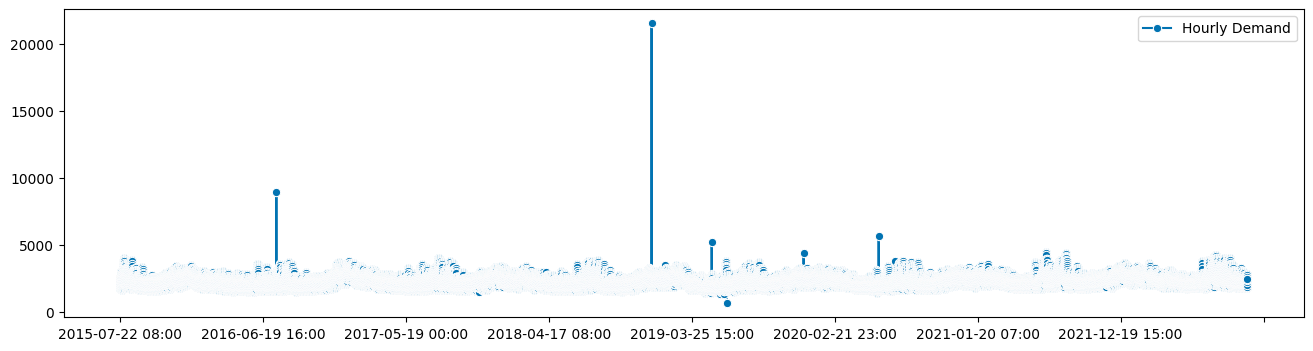

In [16]:
# initial plot of series
plot_series(pge_demand.set_index('utc').sort_index(), labels=['Hourly Demand']);

**Examine Potential High Outliers:**

In [17]:
# potential high outliers
pge_demand[pge_demand['demand_MWh'] > 4400]

,utc,demand_MWh
11248,2021-06-29 01:00,4409.0
11249,2021-06-29 00:00,4471.0
11250,2021-06-28 23:00,4460.0
11251,2021-06-28 22:00,4443.0
11252,2021-06-28 21:00,4417.0
20625,2020-06-03 08:00,5626.0
24825,2019-12-11 08:00,4410.0
29970,2019-05-10 23:00,5193.0
33332,2018-12-12 22:00,21556.0
54330,2016-07-21 00:00,8935.0


- Values 11248 through 11252 are contiguous high-demand, so not outliers. (Also occurred during an intense heatwave, so not surprising)
- Remaining 5 values are the single high-demand points on the graph, and are therefore probably outliers.

In [18]:
# examine values surrounding probable outliers
for i in [20625, 24825, 29970, 33332, 54330]:
    print(pge_demand.iloc[i - 2: i + 3])

                    utc  demand_MWh
20623  2020-06-03 10:00      1645.0
20624  2020-06-03 09:00      1707.0
20625  2020-06-03 08:00      5626.0
20626  2020-06-03 07:00      1917.0
20627  2020-06-03 06:00      2103.0
                    utc  demand_MWh
24823  2019-12-11 10:00      2056.0
24824  2019-12-11 09:00      2135.0
24825  2019-12-11 08:00      4410.0
24826  2019-12-11 07:00      2335.0
24827  2019-12-11 06:00      2659.0
                    utc  demand_MWh
29968  2019-05-11 01:00      2790.0
29969  2019-05-11 00:00      2747.0
29970  2019-05-10 23:00      5193.0
29971  2019-05-10 22:00      2569.0
29972  2019-05-10 21:00      2483.0
                    utc  demand_MWh
33330  2018-12-13 00:00      2709.0
33331  2018-12-12 23:00      2668.0
33332  2018-12-12 22:00     21556.0
33333  2018-12-12 21:00      2718.0
33334  2018-12-12 20:00      2750.0
                    utc  demand_MWh
54328  2016-07-21 02:00      2963.0
54329  2016-07-21 01:00      2968.0
54330  2016-07-21 00:00     

All suspected outliers are indeed improbably different from surrounding values (many standard deviations above, even without accounting for seasonality or trend). These values will be imputed with the mean of the values immediately surrounding them.

In [19]:
# impute
for i in [20625, 24825, 29970, 33332, 54330]:
    pge_demand.at[i, 'demand_MWh'] = (pge_demand.at[i - 1, 'demand_MWh'] + pge_demand.at[i + 1, 'demand_MWh']) / 2

In [20]:
# check
for i in [20625, 24825, 29970, 33332, 54330]:
    print(pge_demand.iloc[i - 2: i + 3])

                    utc  demand_MWh
20623  2020-06-03 10:00      1645.0
20624  2020-06-03 09:00      1707.0
20625  2020-06-03 08:00      1812.0
20626  2020-06-03 07:00      1917.0
20627  2020-06-03 06:00      2103.0
                    utc  demand_MWh
24823  2019-12-11 10:00      2056.0
24824  2019-12-11 09:00      2135.0
24825  2019-12-11 08:00      2235.0
24826  2019-12-11 07:00      2335.0
24827  2019-12-11 06:00      2659.0
                    utc  demand_MWh
29968  2019-05-11 01:00      2790.0
29969  2019-05-11 00:00      2747.0
29970  2019-05-10 23:00      2658.0
29971  2019-05-10 22:00      2569.0
29972  2019-05-10 21:00      2483.0
                    utc  demand_MWh
33330  2018-12-13 00:00      2709.0
33331  2018-12-12 23:00      2668.0
33332  2018-12-12 22:00      2693.0
33333  2018-12-12 21:00      2718.0
33334  2018-12-12 20:00      2750.0
                    utc  demand_MWh
54328  2016-07-21 02:00      2963.0
54329  2016-07-21 01:00      2968.0
54330  2016-07-21 00:00     

**Examine Potential Low Outliers:**

In [21]:
# potential low outliers
pge_demand[pge_demand['demand_MWh'] < 1000]

,utc,demand_MWh
29119,2019-06-15 10:00,630.0
29120,2019-06-15 09:00,662.0


In [22]:
# demand values surrounding low outliers
pge_demand.iloc[29115:29125]

,utc,demand_MWh
29115,2019-06-15 14:00,1715.0
29116,2019-06-15 13:00,1632.0
29117,2019-06-15 12:00,1605.0
29118,2019-06-15 11:00,1598.0
29119,2019-06-15 10:00,630.0
29120,2019-06-15 09:00,662.0
29121,2019-06-15 08:00,1810.0
29122,2019-06-15 07:00,1975.0
29123,2019-06-15 06:00,2179.0
29124,2019-06-15 05:00,2325.0


The potential low outliers seem to be missing a leading 1, i.e., are 1000 smaller than they should be. They will be imputed accordingly.

In [23]:
# impute
for i in [29119, 29120]:
    pge_demand.at[i, 'demand_MWh'] += 1000

In [24]:
# check
pge_demand.iloc[29115:29125]

,utc,demand_MWh
29115,2019-06-15 14:00,1715.0
29116,2019-06-15 13:00,1632.0
29117,2019-06-15 12:00,1605.0
29118,2019-06-15 11:00,1598.0
29119,2019-06-15 10:00,1630.0
29120,2019-06-15 09:00,1662.0
29121,2019-06-15 08:00,1810.0
29122,2019-06-15 07:00,1975.0
29123,2019-06-15 06:00,2179.0
29124,2019-06-15 05:00,2325.0


**Plot Clean Series:**

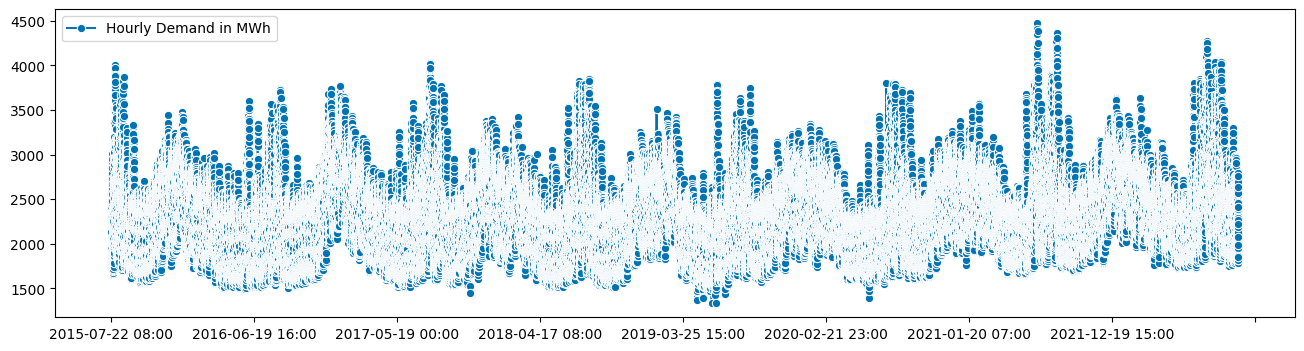

In [25]:
plot_series(pge_demand.set_index('utc').sort_index(), labels=['Hourly Demand in MWh']);

**From previous work (in notebooks/incomplete/pge-composite-forecasts.ipynb), I know entries for 215 hours to be completely missing from the data (not hours with missing values, as cleaned above, but rows entirely absent). Investigatory work and correction below:**

### 4. Investigate Day-of-Week and Hour Misalignment in Plots

In [26]:
pd.period_range(start='2015-07-22 08:00', end='2022-10-10 17:00', freq='H')

PeriodIndex(['2015-07-22 08:00', '2015-07-22 09:00', '2015-07-22 10:00',
             '2015-07-22 11:00', '2015-07-22 12:00', '2015-07-22 13:00',
             '2015-07-22 14:00', '2015-07-22 15:00', '2015-07-22 16:00',
             '2015-07-22 17:00',
             ...
             '2022-10-10 08:00', '2022-10-10 09:00', '2022-10-10 10:00',
             '2022-10-10 11:00', '2022-10-10 12:00', '2022-10-10 13:00',
             '2022-10-10 14:00', '2022-10-10 15:00', '2022-10-10 16:00',
             '2022-10-10 17:00'],
            dtype='period[H]', length=63298)

In [27]:
# set-up y as series with period index
y = pge_demand.set_index('utc')['demand_MWh']

In [28]:
len(y.index.unique())

63083

Original demand series appears to be missing 215 hours. I checked for missing values in original data cleaning, but it did not occur to me that entire entries, i.e., hour and demand, would be missing.

In [39]:
set(pd.period_range(start='2015-07-22 08:00', end='2022-10-10 17:00', freq='H')).symmetric_difference(y.index)

{Period('2019-03-05 09:00', 'H'),
 Period('2019-03-05 10:00', 'H'),
 Period('2019-03-05 11:00', 'H'),
 Period('2019-03-05 12:00', 'H'),
 Period('2019-03-05 13:00', 'H'),
 Period('2019-03-05 14:00', 'H'),
 Period('2019-03-05 15:00', 'H'),
 Period('2019-03-05 16:00', 'H'),
 Period('2019-03-05 17:00', 'H'),
 Period('2019-03-05 18:00', 'H'),
 Period('2019-03-05 19:00', 'H'),
 Period('2019-03-05 20:00', 'H'),
 Period('2019-03-05 21:00', 'H'),
 Period('2019-03-05 22:00', 'H'),
 Period('2019-03-05 23:00', 'H'),
 Period('2019-03-06 00:00', 'H'),
 Period('2019-03-06 01:00', 'H'),
 Period('2019-03-06 02:00', 'H'),
 Period('2019-03-06 03:00', 'H'),
 Period('2019-03-06 04:00', 'H'),
 Period('2019-03-06 05:00', 'H'),
 Period('2019-03-06 06:00', 'H'),
 Period('2019-03-06 07:00', 'H'),
 Period('2019-03-06 08:00', 'H'),
 Period('2019-03-06 09:00', 'H'),
 Period('2019-03-06 10:00', 'H'),
 Period('2019-03-06 11:00', 'H'),
 Period('2019-03-06 12:00', 'H'),
 Period('2019-03-06 13:00', 'H'),
 Period('2019-

In [30]:
len(set(pd.period_range(start='2015-07-22 08:00', end='2022-10-10 17:00', freq='H')).symmetric_difference(y.index))

215

Confirmed: original demand series is missing values for 215 hours.

In [31]:
pd.Period('2019-03-12 07:00', 'H') - pd.Period('2019-03-05 09:00', 'H')

<166 * Hours>

167 missing hours

In [32]:
pd.Period('2019-03-18 07:00', 'H') - pd.Period('2019-03-16 08:00', 'H')

<47 * Hours>

48 missing hours

The 215 missing hours are in two chunks, one of one hour less than a week (3/5/19 09:00 through 3/12/19 07:00), the other exactly two days (3/16/19 08:00 through 3/18/19 07:00). This explains the irregularities observed in plots of forecasting periods whose days of the week and hours should match up but do not.

Imputation Strategy: Impute each hour with the average of the corresponding hours from prior years.

After imputation, iterative modeling procedure will be re-done before moving on to incorporation of exogenous variables.

### 5. Impute Missing Demand Hours, Values

In [33]:
# create df with utc values for missing hours
missing = pd.DataFrame(set(pd.period_range(start='2015-07-22 08:00', end='2022-10-10 17:00', freq='H')).symmetric_difference(y.index)).sort_values(by=0).rename(columns={0: 'utc'})

In [34]:
missing.reset_index(drop=True, inplace=True)

In [35]:
# create list of imputed demand values
missing_demand = []

for missing_period in missing['utc']:
    prev_demand = []
    for found_period in y.index[y.index < pd.Period('2019-01-01 00:00', freq='H')]:
        if missing_period.strftime('%m%d%H%M') == found_period.strftime('%m%d%H%M'):
            prev_demand.append(y.at[found_period])
    missing_demand.append(mean(prev_demand))

In [36]:
# add missing demand values to df
missing['demand_MWh'] = missing_demand

In [37]:
# concatenate missing df to demand df
full_demand = pd.concat([pge_demand, missing]).sort_values(by='utc')

In [38]:
# set-up full_y as series with period index
full_y = full_demand.set_index('utc')['demand_MWh']

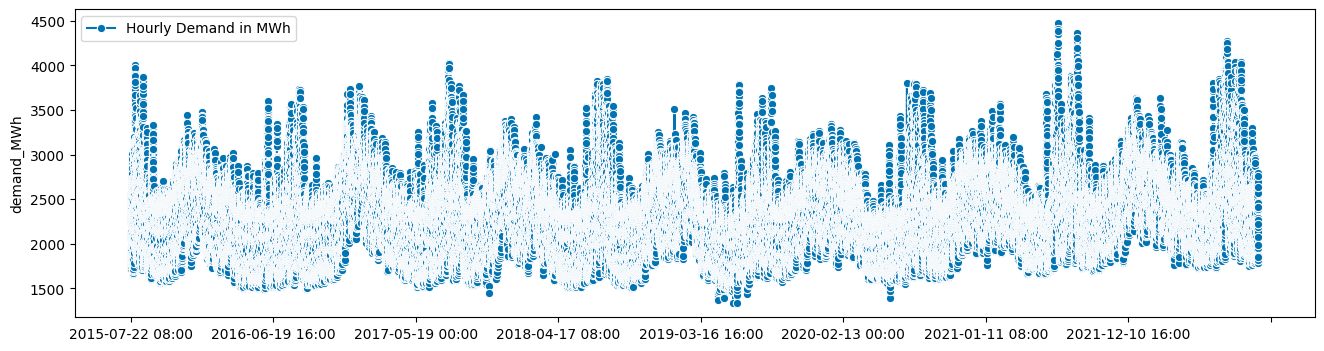

In [40]:
plot_series(full_y, labels=['Hourly Demand in MWh']);

### 6. Save Full Demand Series

In [40]:
full_demand.to_csv('../data/full_pge_demand.csv', index=False)